In [1]:
#神经网络的继续优化 增加momentum rmsprop 以及adam算法 以点的区分为例

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import operator
import sklearn
from functools import reduce
import h5py
import sklearn.datasets

In [3]:
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

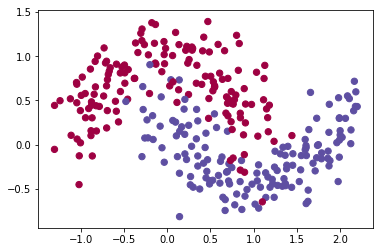

In [4]:
train_X, train_Y = load_dataset()

In [5]:
#使用两层神经网络，使用relu函数和sigmoid函数，第一层n_h节点
def init_paramters_deep(Layer_dims):
    np.random.seed(3)
    paramters = {}
    V = {}
    S = {}
    for i in range(1,len(Layer_dims)):
        paramters['W'+str(i)] = np.random.randn(Layer_dims[i],Layer_dims[i-1])/np.sqrt(Layer_dims[i-1])#这也是个修改点
        paramters['b'+str(i)] = np.zeros((Layer_dims[i],1))
        V['dW'+str(i)] = np.zeros((Layer_dims[i],Layer_dims[i-1]))
        V['db'+str(i)] = np.zeros((Layer_dims[i],1))
        S['dW'+str(i)] = np.zeros((Layer_dims[i],Layer_dims[i-1]))
        S['db'+str(i)] = np.zeros((Layer_dims[i],1))
    return paramters,V,S

In [6]:
#定义激活函数
def activation(x,activate):
    if(activate=='relu'):
        return (abs(x)+x)/2
    if(activate=='sigmoid'):
        return 1/(1+np.exp(-x))

In [7]:
#进行前向传播
def forward(X,paramters,keep_prob):
    cache = {}
    a = X
    cache['A0']=X
    length = len(paramters)//2+1
    for i in range(1,length):
        W = paramters['W'+str(i)]
        b = paramters['b'+str(i)]
        Z = np.dot(W,a)+b
        cache['Z'+str(i)] = Z
        if(i!=length-1):
            a = activation(Z,'relu')
            D = np.random.rand(a.shape[0],a.shape[1])
            D = (D<keep_prob).astype(int) 
            cache['D'+str(i)] = D
            a = a*D
            a =a/keep_prob
        else:
            a = activation(Z,'sigmoid')
        cache['A'+str(i)] = a
    return cache

In [8]:
def forward_without_prob(X,paramters):
    cache = {}
    a = X
    cache['A0']=X
    length = len(paramters)//2+1
    for i in range(1,length):
        W = paramters['W'+str(i)]
        b = paramters['b'+str(i)]
        Z = np.dot(W,a)+b
        cache['Z'+str(i)] = Z
        if(i!=length-1):
            a = activation(Z,'relu')
        else:
            a = activation(Z,'sigmoid')
        cache['A'+str(i)] = a
    return cache    

In [9]:
#计算损失函数
def computeCost(A,Y,lamdb,Layer_dims,parameters):
    m = Y.shape[1]
    reg = 0
    cost = (-1/A.shape[1])*np.nansum((Y*np.log(A))+(1-Y)*np.log(1-A))
    if(lamdb==0):
        return cost
    else:
        for i in range(1,len(Layer_dims)):
            reg +=np.sum(np.square(parameters['W'+str(i)]))
    return cost+(lamdb/(2*m))*reg

In [10]:
#进行反向传播计算
def backward(X,caches,Y,paramters,lamdb,keep_prob):
    m = X.shape[1]
    length = len(paramters)//2+1
    grads={}
    dZ = caches['A'+str(length-1)]-Y
    for i in reversed(range(1,length)):
        w = paramters['W'+str(i)]
        a_prev = caches['A'+str(i-1)]
        dw = (1./m)*np.dot(dZ,a_prev.T)+(lamdb/m)*w
        db = (1./m)*np.sum(dZ,axis=1,keepdims=True)
        if i-1!=0:
            d = caches['D'+str(i-1)]
            da_prev = np.dot(w.T,dZ)*d
            da_prev/=keep_prob
        else:
            da_prev = np.dot(w.T,dZ)
        dZ = np.multiply(da_prev, np.int64(a_prev > 0))#这一步，关键所在
        grads['dW'+str(i)] = dw
        grads['db'+str(i)] = db
    return grads

In [11]:
def backward_without_prob(X,caches,Y,paramters,lamdb):
    m = X.shape[1]
    length = len(paramters)//2+1
    grads={}
    dZ = caches['A'+str(length-1)]-Y
    for i in reversed(range(1,length)):
        w = paramters['W'+str(i)]
        a_prev = caches['A'+str(i-1)]
        dw = (1./m)*np.dot(dZ,a_prev.T)+(lamdb/m)*w
        db = (1./m)*np.sum(dZ,axis=1,keepdims=True)
        da_prev = np.dot(w.T,dZ)
        dZ = np.multiply(da_prev, np.int64(a_prev > 0))#这一步，关键所在
        grads['dW'+str(i)] = dw
        grads['db'+str(i)] = db
    return grads

In [12]:
def update_paramters(paramters,grads,learning_rate):
    length = len(paramters)//2+1
    for i in range(1,length):
        paramters['W'+str(i)] = paramters['W'+str(i)]-learning_rate*grads['dW'+str(i)]
        paramters['b'+str(i)] = paramters['b'+str(i)]-learning_rate*grads['db'+str(i)]
    return paramters

In [13]:
def update_paramters_with_momentum(paramters,grads,learning_rate,V,beta):
    length = len(paramters)//2+1
    for i in range(1,length):
        V['dW'+str(i)] = V['dW'+str(i)]*beta+(1-beta)*grads['dW'+str(i)]
        V['db'+str(i)] = V['db'+str(i)]*beta+(1-beta)*grads['db'+str(i)]
        paramters['W'+str(i)] = paramters['W'+str(i)]-learning_rate*V['dW'+str(i)]
        paramters['b'+str(i)] = paramters['b'+str(i)]-learning_rate*V['db'+str(i)]
    return paramters,V

In [14]:
def update_paramters_with_RMSPorp(paramters,grads,learning_rate,S,beta):
    length = len(paramters)//2+1
    for i in range(1,length):
        S['dW'+str(i)] = S['dW'+str(i)]*beta+(1-beta)*(grads['dW'+str(i)]**2)
        S['db'+str(i)] = S['db'+str(i)]*beta+(1-beta)*(grads['db'+str(i)]**2)
        paramters['W'+str(i)] = paramters['W'+str(i)]-(learning_rate*(grads['dW'+str(i)]))/((np.sqrt(S['dW'+str(i)])+1e-8))
        paramters['b'+str(i)] = paramters['b'+str(i)]-(learning_rate*grads['db'+str(i)])/((np.sqrt(S['db'+str(i)])+1e-8))
    return paramters,S

In [15]:
def update_paramters_with_Adam(paramters,grads,learning_rate,V,S,beta1,beta2,t):
    length = len(paramters)//2+1
    v_corrected=  {}
    s_corrected = {}
    for i in range(1,length):
        V['dW'+str(i)] = V['dW'+str(i)]*beta1+(1-beta1)*grads['dW'+str(i)]
        V['db'+str(i)] = V['db'+str(i)]*beta1+(1-beta1)*grads['db'+str(i)]
        v_corrected["dW" + str(i)] = V["dW" + str(i)]/(1-beta1**t)
        v_corrected["db" + str(i)] = V["db" + str(i)]/(1-beta1**t)
        S["dW" + str(i)] = S["dW" + str(i)]*beta2+(1-beta2)*(grads['dW'+str(i)]**2)
        S["db" + str(i)] = S["db" + str(i)]*beta2+(1-beta2)*(grads['db'+str(i)]**2)
        s_corrected["dW" + str(i)] = S["dW" + str(i)]/(1-beta2**t)
        s_corrected["db" + str(i)] = S["db" + str(i)]/(1-beta2**t)
        paramters["W" + str(i)] = paramters["W" + str(i)]-learning_rate*(v_corrected["dW" + str(i)]/(np.sqrt(s_corrected["dW" + str(i)])+1e-8))
        paramters["b" + str(i)] = paramters["b" + str(i)]-learning_rate*(v_corrected["db" + str(i)]/(np.sqrt(s_corrected["db" + str(i)])+1e-8))
    return paramters,V,S

In [16]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    caches = forward(X, parameters,1)
    a3 = caches['A3']
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [17]:
def create_batch(X,Y,batch_size):
    total_num = X.shape[1]
    batch_num = 0
    mini_batchs = []
    permutation = list(np.random.permutation(total_num))
    shuffle_x = X[:,permutation]
    shuffle_y = Y[:,permutation]
    if total_num%batch_size==0:
        batch_num = (int)(total_num/batch_size)
        for i in range(batch_num):
            mini_batch = (shuffle_x[:,i*batch_size:(i+1)*batch_size],shuffle_y[:,i*batch_size:(i+1)*batch_size])
            mini_batchs.append(mini_batch)
    else:
        batch_num = (int)(total_num/batch_size)+1
        for i in range(batch_num-1):
            mini_batch = (shuffle_x[:,i*batch_size:(i+1)*batch_size],shuffle_y[:,i*batch_size:(i+1)*batch_size])
            mini_batchs.append(mini_batch)
        left= (shuffle_x[:,(batch_num-1)*batch_size:],shuffle_y[:,(batch_num-1)*batch_size:])
        mini_batchs.append(left)
    return np.array(mini_batchs)

In [18]:
#建立浅层神经网络模型
def nn_model(X,Y,learning_rate,epochs,layer_dims,lamdb,keep_prob,batch_size,optimizer=None,beta1=0.9,beta2=0.999):
    losses = []
    paramters,V,S = init_paramters_deep(layer_dims)#完全一致
    length = len(layer_dims)
    mini_batchs = create_batch(X,Y,batch_size)
    t = 0
    for i in range(epochs):
        for mini_batch in mini_batchs:
            mini_X = mini_batch[0]
            mini_Y  = mini_batch[1]
            if(keep_prob==1):
                caches=forward_without_prob(mini_X,paramters)
                grads = backward_without_prob(mini_X,caches,mini_Y,paramters,lamdb)
            else:
                caches = forward(mini_X,paramters,keep_prob)
                grads = backward(mini_Y,caches,Y,paramters,lamdb,keep_prob)
            if optimizer=='momentum':
                paramters,V  = update_paramters_with_momentum(paramters,grads,learning_rate,V,beta1)
            if optimizer==None:
                paramters = update_paramters(paramters,grads,learning_rate)
            if optimizer=='RMSProp':
                paramters,S  = update_paramters_with_RMSPorp(paramters,grads,learning_rate,S,beta2)
            if optimizer=='Adam':
                t =t+1
                paramters,V,S = update_paramters_with_Adam(paramters,grads,learning_rate,V,S,beta1,beta2,t)
        cost = computeCost(caches['A'+str(length-1)],mini_Y,lamdb,layer_dims,paramters)
        losses.append(cost)
        if i%1000==0:
            print(cost)
    plt.plot(losses)
    return paramters,losses

In [20]:
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    cache = forward(X, parameters,1)
    a3 = cache['A3']
    predictions = (a3>0.5)
    return predictions

In [22]:
layer_dims = [train_X.shape[0],5,2,1]

0.6956186456474642
0.6928976620977108
0.6901735420664207
0.6874690975330923
0.6846104244313238
0.6816755480292979
0.6784698564991741
0.6750241377489672
0.6714915499224555
0.6677788359148483
On the training set:
Accuracy: 0.66


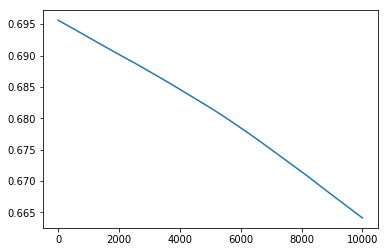

In [24]:
parameters,loss = nn_model(train_X, train_Y,0.0007,10000,layer_dims,0,1,train_X.shape[1])
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)#使用普通梯度下降算法 正确率较低

0.6973685534598529
0.680631801041927
0.6584576916696997
0.6268435500788779
0.5775901915037805
0.520370350336126
0.46204695144210917
0.38380138115723844
0.32001622758220194
0.2779269983781014
On the training set:
Accuracy: 0.8533333333333334


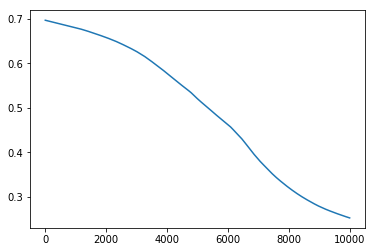

In [25]:
parameters,loss = nn_model(train_X, train_Y,0.0007,10000,layer_dims,0,1,64)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)#使用mini-batch算法，提高了准确率

0.6973765886196607
0.6806691540952633
0.6585253082436363
0.6269808172982672
0.5778278462854292
0.5206904515662584
0.46234556279736067
0.38434054767493847
0.3203629435703604
0.27812846873038116
On the training set:
Accuracy: 0.8533333333333334


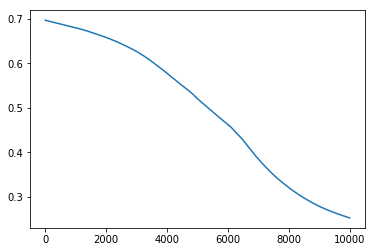

In [27]:
parameters,loss = nn_model(train_X, train_Y,0.0007,10000,layer_dims,0,1,64,optimizer='momentum')
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)#使用momentum算法

0.6834740217234289
0.08785777609569537
0.07258545446064175
0.07014157115259581
0.07009429622721318
0.0694822974995511
0.06903228300964069
0.06867348480386777
0.06835482832895386
0.06835678667989722
On the training set:
Accuracy: 0.9433333333333334


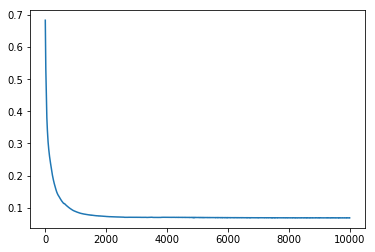

In [28]:
parameters,loss = nn_model(train_X, train_Y,0.0007,10000,layer_dims,0,1,64,optimizer='RMSProp')
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)#使用RMSProp算法

0.6966703829263775
0.10213104209961635
0.07387082858807727
0.06963324681217585
0.06933459754760715
0.06900670304422708
0.06842404536922989
0.06815156317394759
0.06781260096615899
0.06773337044912268
On the training set:
Accuracy: 0.94


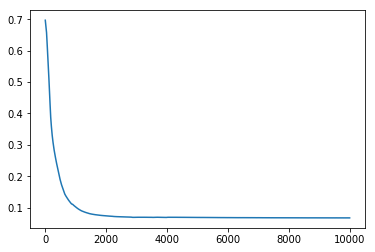

In [29]:
parameters,loss = nn_model(train_X, train_Y,0.0007,10000,layer_dims,0,1,64,optimizer='Adam')
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)#使用Adam算法